In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [4]:
%pip install nltk -U

Note: you may need to restart the kernel to use updated packages.


In [5]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [7]:
sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

Original spark.driver.maxResultSize: 1920m


### Read the dataset

In [8]:
path = 'gs://msca-bdp-students-bucket/shared_data/qsliu/clean_df'

clean_df = spark.read.parquet(path)

In [9]:
clean_df.limit(5)

created_at,favorite_count,tweet_location_type,tweet_location,tweet_country,quote_count,reply_count,retweet_count,retweeted,retweeted_from,source,tweet_text,timestamp_ms,user_id,user_name,user_screen_name,user_description,user_location,user_verified,followers_count
Fri Apr 15 14:29:...,0,null,null,null,0,0,null,,null,"<a href=""https://...",join us 4/25 for ...,1650032952617,1514974123751088133,MIT.nano,mit_nano,We measure the fu...,"Cambridge, Massac...",false,1522
Fri Apr 15 14:29:...,0,null,null,null,0,0,null,,null,"<a href=""https://...",georgia milestone...,1650032953591,1514974127836352514,Annie Belle Clark...,ABCES_Tift,null,null,false,160
Fri Apr 15 14:29:...,0,null,null,null,0,0,54,RT,EAlexander46,"<a href=""http://t...",a teacher for mor...,1650032954449,1514974131434971140,dan marshall,dan09507253,Ontario correctio...,null,false,243
Fri Apr 15 14:29:...,0,null,null,null,0,0,null,,null,"<a href=""http://t...",my intro to polit...,1650032954528,1514974131766366210,Taylor Brown,taylorsbrown,Christian. @oksta...,"Waco, TX",false,1862
Fri Apr 15 14:29:...,0,null,null,null,0,0,236,RT,damiengayle,"<a href=""http://t...",prof colin davis ...,1650032954697,1514974132475252741,Guio,GuiomarListe,De mayor quiero s...,"Saragossa, Spain",false,41


In [9]:
df = clean_df

In [11]:
count_tw = df.count()
count_tw

99178473

In [12]:
df.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- tweet_location_type: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- tweet_country: string (nullable = true)
 |-- quote_count: long (nullable = true)
 |-- reply_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- retweeted: string (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- source: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_verified: boolean (nullable = true)
 |-- followers_count: long (nullable = true)



In [10]:
df = df.withColumn('year', substring('created_at', 27, 4))
df = df.withColumn('month', substring('created_at', 5, 3))
df = df.withColumn('time', substring('created_at',12,2))
df = df.withColumn('day_of_week', substring('created_at',1,3))
df = df.withColumn('month_year', concat(substring('created_at', 5, 3), lit(' '), substring('created_at', 27, 4)))

In [14]:
df.limit(5)

created_at,favorite_count,tweet_location_type,tweet_location,tweet_country,quote_count,reply_count,retweet_count,retweeted,retweeted_from,source,tweet_text,timestamp_ms,user_id,user_name,user_screen_name,user_description,user_location,user_verified,followers_count,year,month,time,day_of_week
Mon Aug 08 20:46:...,0,null,null,null,0,0,303,RT,lindoyle2,"<a href=""http://t...",@calltoactivism w...,1659991587401,1556743665460170754,Kenneth Eissner,keeissner,"Dems= democracy, ...",null,false,3794,2022,Aug,20,Mon
Mon Aug 08 20:46:...,0,null,null,null,0,0,null,,UChicago Harris S...,"<a href=""https://...",📢🚨 epe communit...,1659991587417,1556743665527267331,Equity In Policy ...,equityinpolicy,Mentoring Bahujan...,Working from home,false,1638,2022,Aug,20,Mon
Mon Aug 08 20:46:...,0,null,null,null,0,0,null,,null,"<a href=""http://t...",if you stan an el...,1659991587491,1556743665837494272,kay~ 📁,chaemosa,she/her 21 | 🇲🇽,ur mom | twice | ...,false,2258,2022,Aug,20,Mon
Mon Aug 08 20:46:...,0,null,null,null,0,0,null,,null,"<a href=""https://...",@tooths_alt i rem...,1659991587825,1556743667238461442,NachosUnlimited,NachosUnlimited,I love the union ...,null,false,13,2022,Aug,20,Mon
Mon Aug 08 20:46:...,0,null,null,null,0,0,12488,RT,asIiceofhistory,"<a href=""https://...",high school stude...,1659991587826,1556743667242737664,Serizawa,dasprasident,No follow-back.,"Chūō, Tokio",false,101,2022,Aug,20,Mon


### Year/Season

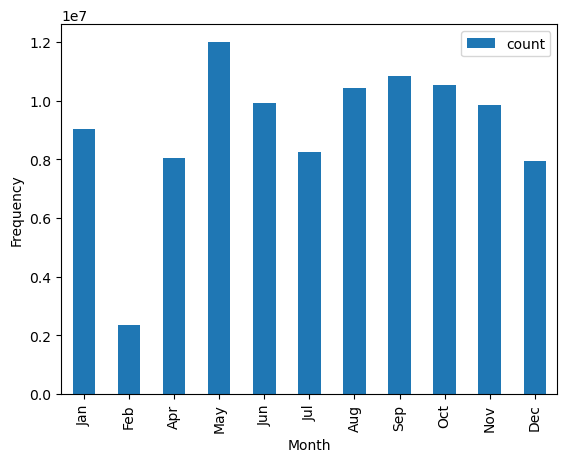

In [15]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

month_counts_pd = df.groupBy("month").count().toPandas()

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

mapping = {day: i for i, day in enumerate(month_order)}
key = month_counts_pd['month'].map(mapping)    
month_counts_pd = month_counts_pd.iloc[key.argsort()]

month_counts_pd.plot(kind='bar', x='month')

#month_counts_pd.plot(kind="bar", x="month", y="count")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.show()

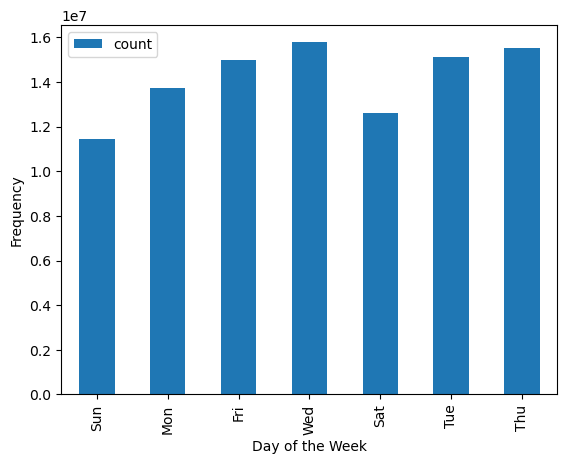

In [16]:
day_counts_pd = df.groupBy("day_of_week").count().toPandas()

day_order = ['Sun','Mon','Tue','Wed','Thur','Fri','Sat']

mapping = {day: i for i, day in enumerate(day_order)}
key = day_counts_pd['day_of_week'].map(mapping)    
day_counts_pd = day_counts_pd.iloc[key.argsort()]

day_counts_pd.plot(kind='bar', x='day_of_week')

#day_counts_pd.plot(kind="bar", x="day_of_week", y="count")
plt.xlabel("Day of the Week")
plt.ylabel("Frequency")
plt.show()

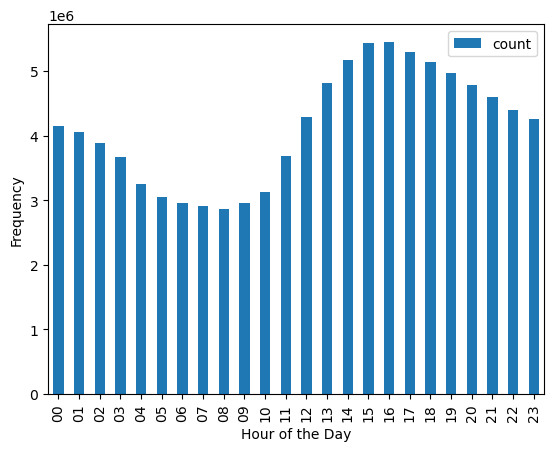

In [17]:
time_counts_pd = df.groupBy("time").count().sort("time").toPandas()

time_counts_pd.plot(kind="bar", x="time", y="count")
plt.xlabel("Hour of the Day")
plt.ylabel("Frequency")
plt.show()

### Who are tweeting on Twitter?

In [11]:
government = ['government','state','public','mayor','senat(e)?(or)?', 'gov', 'jurisdiction', 'regime', 'congress', 'federal']
higher_education = ['universit(y)?(ies)?', 'professor(s)?', 'college(s)?', 'research', 'admission', 'undergrad(udate)?']
k_12 = ['school(s)?', 'middle', 'high', 'elementary','teacher', 'primary', 'secondary'] #k-12
non_profit = ['non-profit', 'ngo']
news_related = ['news', 'newspaper(s)?', 'journal(s)?', 'tv', 'website(s)?', 'magazine', 'report', 'dispatch', 'notice']

In [12]:
df = df.withColumn('user_affiliated_organization', when(df.user_description.rlike('|'.join(government)),'government').\
                   when(df.user_description.rlike('|'.join(higher_education)),'higher_education').\
                   when(df.user_description.rlike('|'.join(k_12)),'k_12').\
                   when(df.user_description.rlike('|'.join(non_profit)),'non_profit').\
                   when(df.user_description.rlike('|'.join(news_related)),'news_related').\
                   otherwise('other'))

In [20]:
df.limit(5)

created_at,favorite_count,tweet_location_type,tweet_location,tweet_country,quote_count,reply_count,retweet_count,retweeted,retweeted_from,source,tweet_text,timestamp_ms,user_id,user_name,user_screen_name,user_description,user_location,user_verified,followers_count,year,month,time,day_of_week,user_affiliated_organization
Fri Apr 29 18:23:...,0,null,null,null,0,0,31,RT,MalluArjun_Army,"<a href=""http://t...",craze for #pushpa...,1651256615673,1520106538601431042,Jai bunnyism 🙏 🔥,HeroFavourite,#PushpaTheRule,"Andhra Pradesh, I...",false,418,2022,Apr,18,Fri,other
Fri Apr 29 18:23:...,0,null,null,null,0,0,null,,bengals_sans Ever...,"<a href=""http://t...",@lakersvegas24 @b...,1651256615653,1520106538517598209,alexT,Midwestreaper24,Huge sports fanat...,"Indianapolis, IN",false,18,2022,Apr,18,Fri,other
Fri Apr 29 18:23:...,0,null,null,null,0,0,12583,RT,chismosavirus,"<a href=""http://t...",i wanna make more...,1651256615783,1520106539062812673,champion.,godfimihan,Daily offender𓃶 ...,cogunsina@gmail.com,false,998,2022,Apr,18,Fri,other
Fri Apr 29 18:23:...,0,null,null,null,0,0,null,,"grvishal1, I hel...","<a href=""https://...","hey @grvishal1, ...",1651256615865,1520106539406798848,Juliette,Juliett50635156,null,null,false,0,2022,Apr,18,Fri,other
Fri Apr 29 18:23:...,0,null,null,null,0,0,null,,"FredericSalloum, ...","<a href=""https://...",hey @fredericsall...,1651256615981,1520106539893374978,Lois,Lois53243094,null,null,false,0,2022,Apr,18,Fri,other


In [21]:
text = df.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
            .map( lambda document: document.strip().lower())\
            .map( lambda document: re.split(" ", document))\
            .map( lambda word: [x for x in word if x.isalnum()])\
            .map( lambda word: [x for x in word if x not in StopWords])\
            .map( lambda word: [x for x in word if len(x) > 3] ) \
            .map( lambda word: ' '.join(word))

In [22]:
tokens.take(5)

['college attended wants nothing kinda like',
 'community event harris join open presentation university application process equity diversity 10th link',
 'stan elementary school class talk',
 'remember elementary school like dedicated showing pictures family serving playing never forget like grade teacher said black spots',
 'high school']

In [23]:
%%time

wordCounts = tokens.flatMap(lambda text: text.split(' ')) \
                    .map(lambda word: (word, 1)) \
                    .reduceByKey(lambda a, b: a+b)


wordCountsSorted = wordCounts.map(lambda x:(x[1],x[0])).sortByKey(ascending=False)

CPU times: user 547 ms, sys: 91.8 ms, total: 639 ms
Wall time: 9min 46s


In [24]:
wordCountsSorted.take(60)

[(46730255, 'school'),
 (13142300, 'college'),
 (10485482, 'university'),
 (9941284, 'high'),
 (8489925, 'schools'),
 (6424243, 'students'),
 (6145639, 'like'),
 (4900205, 'kids'),
 (4770966, 'people'),
 (3859045, 'children'),
 (3600521, 'would'),
 (3553623, 'public'),
 (3550440, 'professor'),
 (3412821, 'back'),
 (3310736, 'student'),
 (3283620, 'time'),
 (3176766, 'first'),
 (3021558, 'know'),
 (3003901, 'need'),
 (2998247, 'year'),
 (2982792, 'want'),
 (2782772, 'going'),
 (2739004, 'make'),
 (2723719, 'state'),
 (2682935, 'years'),
 (2615206, 'even'),
 (2551203, 'education'),
 (2526022, 'help'),
 (2521737, 'think'),
 (2504795, 'every'),
 (2369726, 'still'),
 (2353474, 'football'),
 (2311804, 'never'),
 (2303130, 'went'),
 (2265748, 'today'),
 (2200851, 'good'),
 (2174589, 'also'),
 (2135759, 'parents'),
 (2123444, 'take'),
 (2111631, 'many'),
 (2088702, 'teacher'),
 (2042095, 'teachers'),
 (2038586, 'work'),
 (2018547, 'home'),
 (2002289, 'live'),
 (1996638, 'free'),
 (1960602, 'sa

### What topics related to education are trending on Twitter?

In [13]:
topics = ['education', 'edchat(RI)?', 'e(learn?)(learning)?(teach)?(teaching)?(ed)?(education)?',
          'distance(learn?)(learning)?(teach)?(teaching)?(ed)?(education)?', 
          'online(learn?)(learning)?(teach)?(teaching)?(ed)?(education)?', 
          'edtech', 'learning', 'teaching', 'remote(learn?)(learning)?(teach)?(teaching)?(ed)?(education)?', 
          'zoom(learn?)(learning)?(teach)?(teaching)?(ed)?(education)?', 
          'virtual(learn?)(learning)?(teach)?(teaching)?(ed)?(education)?', 
          'blended(learn?)(learning)?(teach)?(teaching)?(ed)?(education)?', 
          'digital(learn?)(learning)?(teach)?(teaching)?(ed)?(education)?',
          'onlineclass(es)?', 'remoteclass(es)?', 'hybrid', 'remotestudent']



#education
#edchat
#elearning
#highered
#teaching
#STEMeducation
#distancelearning
#onlinelearning
#edtech
#learning
#schoolreopening
#teachersofinstagram
#remotelearning
#collegelife
#studentlife
#virtualLearning
#eLearning
#remoteteaching
#blendedlearning
#digitallearning
#edchatRI

In [14]:
topic_expr = df.tweet_text.contains(topics[0])

for topic in topics[1:]:
    topic_expr |= df.tweet_text.contains(topic)

elearning_df = df.filter(topic_expr)

In [15]:
topic_tw_count = elearning_df.count()
topic_tw_count

5980433

In [28]:
(topic_tw_count/count_tw)*100

6.029970838530656

In [16]:
all_original = df.filter(df.retweeted_from.isNull()).groupby('user_screen_name').count().sort(desc(count('unique_id'))).limit(20).toPandas()
topic_original = elearning_df.filter(elearning_df.retweeted_from.isNull()).groupby('user_screen_name').count().sort(desc(count('unique_id'))).limit(20).toPandas()

In [17]:
user_original_tweet = pd.concat([all_original, topic_original], axis=1)
user_original_tweet

,user_screen_name,count,user_screen_name,count
0,IntenseHeatLA,38184,NJSchoolJobs,10442
1,ana92479235,14846,poet_this,3051
2,madlibs_bot,14802,poskeos,2796
3,sport9920,14411,dealsoftakis,2502
4,AndrianyRahmah,12716,Shopyazanophu33,2425
5,NJSchoolJobs,10459,imbatman2018,2370
6,onepostguy,9712,AJBlackston,1989
7,DennisStemmle,9284,StigmabaseN,1942
8,AgiwaraS,9016,EducationNews_b,1794
9,letsdoyouracads,8929,DennisStemmle,1724


In [18]:
all_retweet = df.groupby('user_screen_name').agg(sum('retweet_count')).sort(desc(sum('retweet_count'))).limit(10).toPandas()
topic_retweet = elearning_df.groupby('user_screen_name').agg(sum('retweet_count')).sort(desc(sum('retweet_count'))).limit(10).toPandas()

In [19]:
user_retweet = pd.concat([all_retweet, topic_retweet], axis=1)
user_retweet

,user_screen_name,sum(retweet_count),user_screen_name,sum(retweet_count)
0,MrTAchilles,4667717,rarewillows,633105
1,purevdo27046751,3791202,NasimiShabnam,539588
2,JesusNarrowWay,3558018,DorisMoonlight,378443
3,Barbtomko1,2899132,iamochola,331298
4,1FreshTake,2742311,Cheryl25044450,257767
5,nroesoroes,2487725,boraxmeatballs,233417
6,thatblackkyddd,2332537,ughhnika,232379
7,MaryMary0414,2326651,MrTAchilles,232362
8,Joni_Looking,2308984,clearlycrystalz,231784
9,DigitalMeowMix,2277282,Lunaablackk96,231747


In [20]:
# organization, retweet
all_retweet_org = df.groupby('user_affiliated_organization').agg(sum('retweet_count')).sort(desc(sum('retweet_count'))).limit(10).toPandas()
topic_retweet_org = elearning_df.groupby('user_affiliated_organization').agg(sum('retweet_count')).sort(desc(sum('retweet_count'))).limit(10).toPandas()

In [21]:
org_retweet = pd.concat([all_retweet_org, topic_retweet_org], axis=1)
org_retweet

,user_affiliated_organization,sum(retweet_count),user_affiliated_organization,sum(retweet_count)
0,other,129807364273,other,5693598787
1,government,1587714235,government,86789178
2,k_12,1186363133,k_12,68292074
3,news_related,1173320520,news_related,59695409
4,higher_education,544002143,higher_education,30789952
5,non_profit,248976970,non_profit,11320262


In [22]:
all_original_user = df.filter(df.retweeted_from.isNull()).groupby('user_affiliated_organization').count().sort(desc(count('unique_id'))).limit(20).toPandas()
topic_original_user = elearning_df.filter(elearning_df.retweeted_from.isNull()).groupby('user_affiliated_organization').count().sort(desc(count('unique_id'))).limit(20).toPandas()

In [23]:
org_original_tweet = pd.concat([all_original_user, topic_original_user], axis=1)
org_original_tweet

,user_affiliated_organization,count,user_affiliated_organization,count
0,other,26350179,other,1128822
1,news_related,1049904,k_12,103927
2,k_12,928244,news_related,60329
3,government,512731,government,44037
4,higher_education,426454,higher_education,37129
5,non_profit,59150,non_profit,5640


[Text(0.5, 1.0, "Distribution of Original Tweets by Users' Organization Types")]

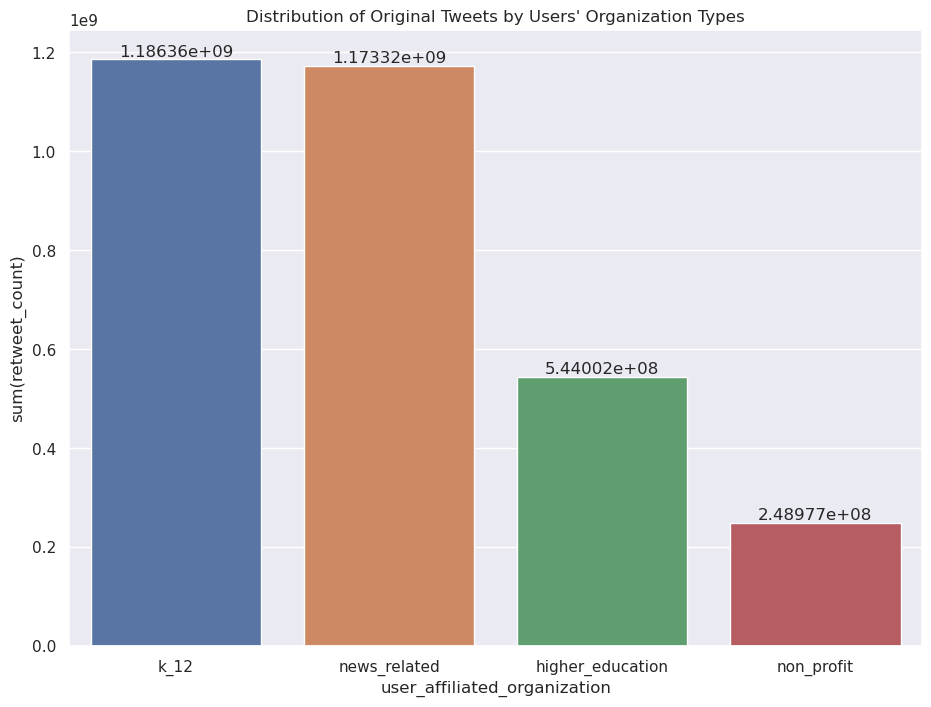

In [24]:
org_retweet_sliced = org_retweet.iloc[-4:, :]

sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(x = org_retweet_sliced.iloc[:,0], y = org_retweet_sliced.iloc[:,1])
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set(title="Distribution of Original Tweets by Users' Organization Types")

[Text(0.5, 1.0, "Distribution of Original Tweets by Users' Organization Types (Filtered Data - ELearning)")]

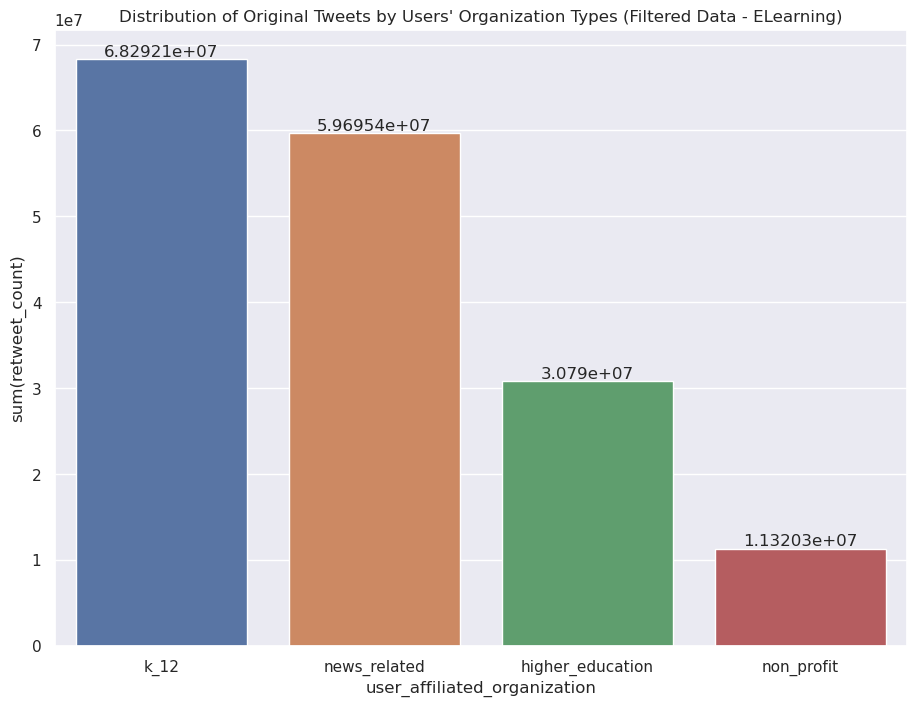

In [25]:
org_retweet_sliced = org_retweet.iloc[-4:, :]

sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(x = org_retweet_sliced.iloc[:,2], y = org_retweet_sliced.iloc[:,3])
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set(title="Distribution of Original Tweets by Users' Organization Types (Filtered Data - ELearning)")

### Location

In [31]:
from pyspark.sql.functions import isnull

df.filter(~isnull('tweet_location')).count()

877232

In [16]:
df.filter(~isnull('user_location')).count()

60399364

In [41]:
print(elearning_df.filter(~isnull('tweet_location')).count())
print(elearning_df.filter(~isnull('user_location')).count())

56195


3704705


In [44]:
print((56195/5980433)*100)
print((3704705/5980433)*100)

0.9396476810291161
61.9471031612594


In [46]:
#df.select('user_location').limit(20)

In [47]:
#df.select(substring_index(df['user_location'], ',', 1)).limit(20)

In [15]:
elearning_df = elearning_df.withColumn('user_location_specific', substring_index(df['user_location'], ',', 1))
elearning_df = elearning_df.withColumn('tweet_location_specific', substring_index(df['tweet_location'], ',', 1))

In [50]:
location_user = elearning_df.groupby('user_location_specific').count().sort(desc(count("user_location_specific"))).limit(20).toPandas()
location_tweet = elearning_df.groupby('tweet_location_specific').count().sort(desc(count("tweet_location_specific"))).limit(20).toPandas()

In [51]:
location = pd.concat([location_user, location_tweet],axis=1)
location

,user_location_specific,count,tweet_location_specific,count
0,United States,71155,Riyadh,1297
1,London,52415,Providence,869
2,Lagos,47249,Oakland,687
3,India,37081,New Delhi,674
4,Nigeria,35635,Florida,663
5,New York,33573,Punganuru,552
6,Washington,30591,Michigan,542
7,USA,27494,Texas,467
8,Texas,26216,Houston,448
9,California,25919,Los Angeles,388


In [54]:
to_remove = ['United States', 'India', 'USA', 'United Kingdom', 'Canada', 'UK']

location_copy = location.copy()

for place in to_remove:
    location_copy = location_copy[location_copy['user_location_specific'] != place]

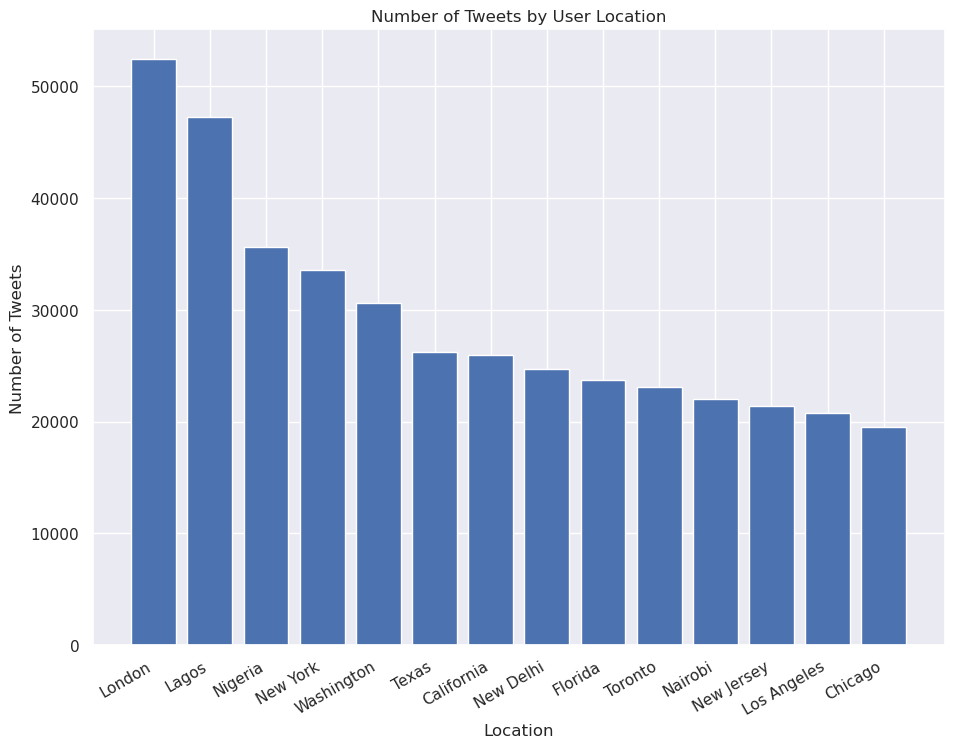

In [55]:
x = location_copy['user_location_specific']
y = location_copy.iloc[:, 1]

plt.bar(x,y)
plt.ylabel('Number of Tweets')
plt.xlabel('Location')
plt.title('Number of Tweets by User Location')
plt.xticks(rotation=30, ha='right')
plt.show()

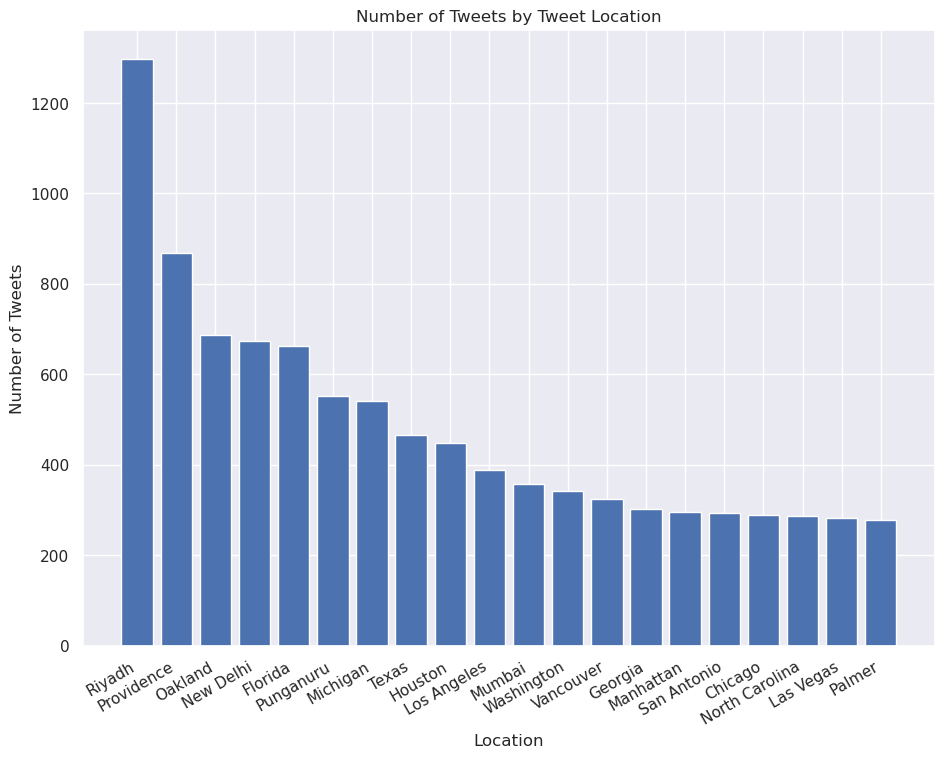

In [53]:
x = location['tweet_location_specific']
y = location.iloc[:, 3]

plt.bar(x,y)
plt.ylabel('Number of Tweets')
plt.xlabel('Location')
plt.title('Number of Tweets by Tweet Location')
plt.xticks(rotation=30, ha='right')
plt.show()

### Year (ELearning)

In [26]:
df.agg(countDistinct('month_year')).limit(20)

count(month_year)
11


In [27]:
elearning_df.agg(countDistinct('month_year'))

count(month_year)
11


23/02/26 21:04:32 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 51 for reason Container marked as failed: container_1677442744738_0002_01_000051 on host: hub-msca-bdp-dphub-students-backup-qsliu-sw-kwwb.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/02/26 21:04:32 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 46 for reason Container marked as failed: container_1677442744738_0002_01_000046 on host: hub-msca-bdp-dphub-students-backup-qsliu-sw-kwwb.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/02/26 21:04:32 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 51 on hub-msca-bdp-dphub-students-backup-qsliu-sw-kwwb.c.msca-bdp-students.internal: Container marked as failed: container_1677442744738_0002_01_000051 on hos

In [29]:
time = elearning_df.groupby('month_year').agg(count('unique_id').alias('tweets_count')).toPandas()
time['month_year'] = time['month_year'].astype('datetime64[ns]')

[Text(0.5, 1.0, 'Number of Tweets Posted per Day')]

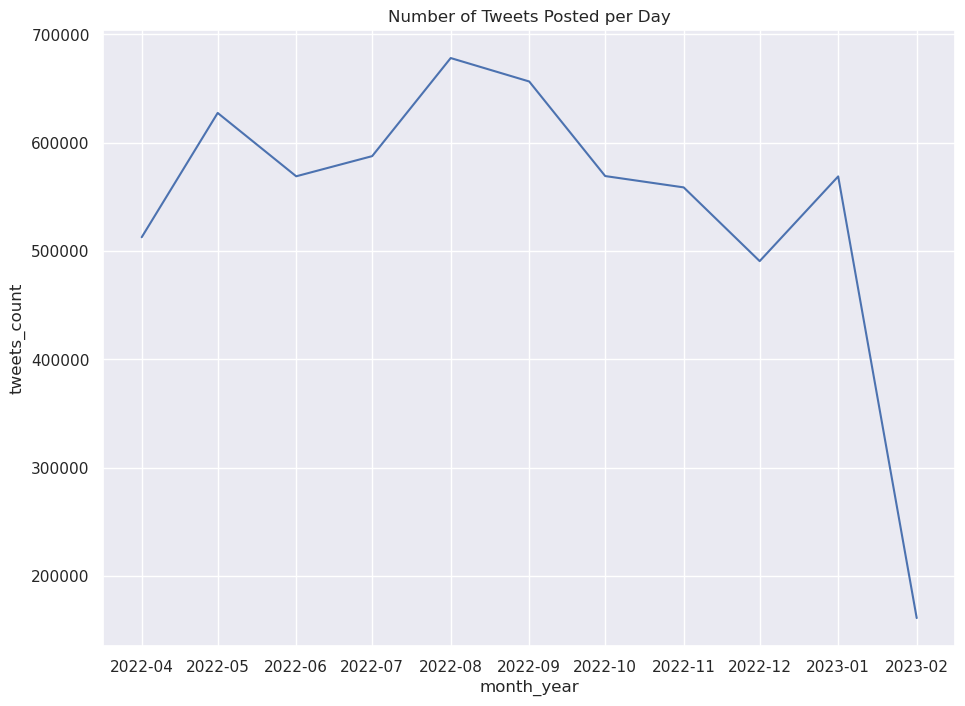

In [30]:
sns.set(rc={'figure.figsize':(11,8)})
sns.lineplot(x = time['month_year'], y = time['tweets_count']).set(title = 'Number of Tweets Posted per Day')

In [32]:
hour = elearning_df.groupby('time').agg(count('unique_id').alias('tweets_count')).toPandas()
#hour['hour'] = time['hour'].astype('datetime64[ns]')

In [39]:
hour = hour.sort_values('time')

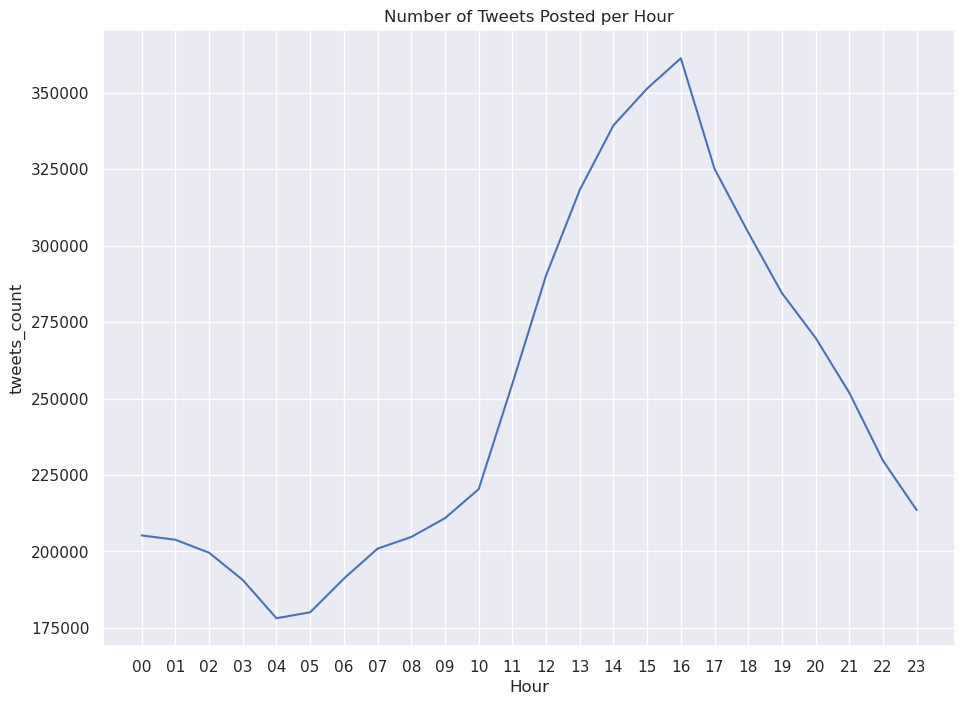

In [40]:
sns.set(rc={'figure.figsize':(11,8)})
sns.lineplot(x = hour['time'], y = hour['tweets_count'])
plt.title('Number of Tweets Posted per Hour')
plt.xlabel('Hour')
plt.show()

### Duplicates

In [16]:
text_df = elearning_df.select(['tweet_text', 'user_affiliated_organization'])

In [17]:
text_df.count()

5980433

In [18]:
sample = text_df.sample(0.0015).limit(5000)
sample.count()

5000

In [19]:
text = sample.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .zipWithIndex()

In [20]:
row = Row('tweet_text')
df_text = text.map(row).zipWithIndex().toDF(['tweet_text','id'])
df_text.limit(5)

tweet_text,id
{having an “if yo...,0
{@helenckh so wha...,1
{one of the great...,2
{grab a new book ...,3
{i went to school...,4


In [21]:
df_tokens_text = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens_text = df_tokens_text.where(col('list_of_words').getItem(0).isNotNull())

In [22]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_text = vectorize.fit(df_tokens_text).transform(df_tokens_text)

In [23]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize_text)
df_hashed = mh.fit(df_vectorize_text).transform(df_vectorize_text)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

#### jaccard distance = 0.3

In [24]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B'))

In [25]:
df_dups_30 = df_dups_text

In [26]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques_30 = records - dups
dups_30 = dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques_30)

Total records:  5000
Duplicate titles based on { 0.3 } jaccard distance:  574
Unique titles based on { 0.3 } jaccard distance:  0.3 :  4426


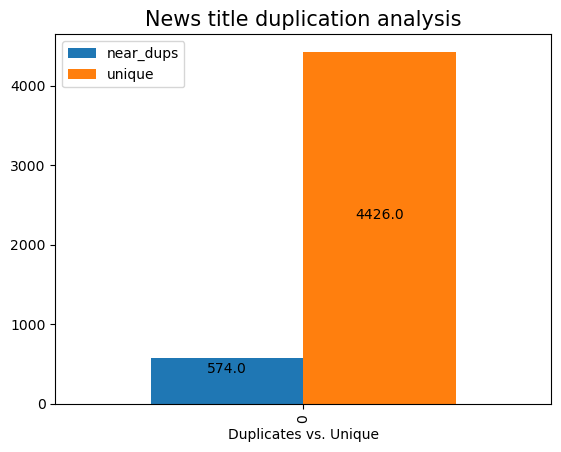

In [27]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques_30]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [28]:
dups_30/records

0.1148

#### jaccard distance = 0.5

In [29]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B'))

In [30]:
df_dups_50 = df_dups_text

In [31]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques_50 = records - dups
dups_50 = dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques_50)

Total records:  5000
Duplicate titles based on { 0.5 } jaccard distance:  616
Unique titles based on { 0.5 } jaccard distance:  0.5 :  4384


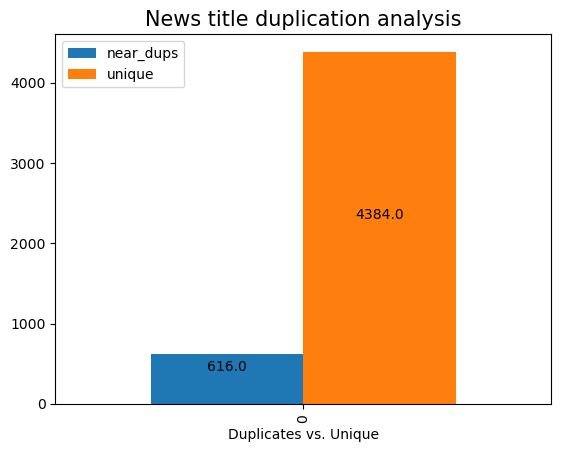

In [32]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_50], 'unique': [uniques_50]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [33]:
dups_50/records

0.1232

#### jaccard_distance = 0.7

In [34]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B'))

In [35]:
df_dups_70 = df_dups_text

In [36]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques_70 = records - dups
dups_70 = dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques_70)

Total records:  5000
Duplicate titles based on { 0.7 } jaccard distance:  675
Unique titles based on { 0.7 } jaccard distance:  0.7 :  4325


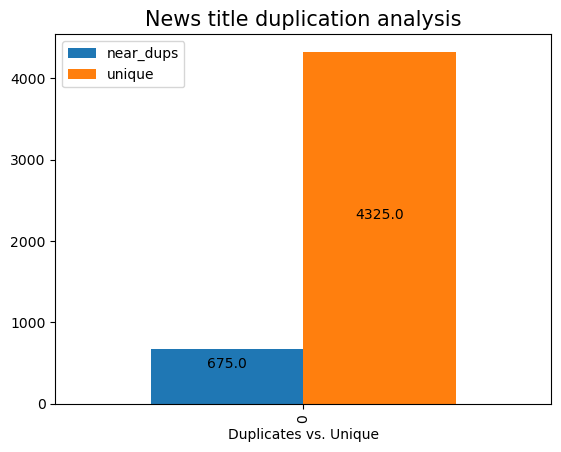

In [37]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_70], 'unique': [uniques_70]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### jaccard distance = 0.1

In [38]:
jaccard_distance = 0.1

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B'))

In [39]:
df_dups_10 = df_dups_text

In [40]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques_10 = records - dups
dups_10 = dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques_10)

Total records:  5000
Duplicate titles based on { 0.1 } jaccard distance:  512
Unique titles based on { 0.1 } jaccard distance:  0.1 :  4488


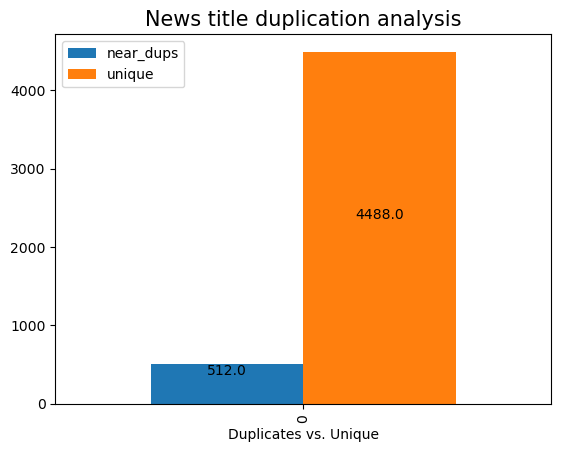

In [41]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_10], 'unique': [uniques_10]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [42]:
df_dups_10_id = df_dups_10.select(col('id_A').alias('id_10_A'), col('id_B').alias('id_10_B'))
df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_id = df_dups_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_id = df_dups_70.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

In [43]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")\
.join(df_dups_10_id, on=((df_dups_70_id.id_70_A == df_dups_10_id.id_10_A) & (df_dups_70_id.id_70_B == df_dups_10_id.id_10_B)), how="left_outer")

In [44]:
dups_combined = dups_combined.\
withColumn("threshold_10",\
           when(col("id_10_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_10_A', 'id_10_B', 'id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

In [45]:
dups_combined_sample = \
dups_combined.filter(("threshold_10 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
union\
(dups_combined.filter(("threshold_10 == 'Non-Dup' and threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
union\
(dups_combined.filter(("threshold_30 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
orderBy('threshold_10','threshold_30', 'threshold_50')

In [46]:
pd.set_option('display.max_rows', 15)
dups_combined_sample.toPandas()

,text_A,text_B,threshold_10,threshold_30,threshold_50,threshold_70
0,"(#blockchain 🤝 education\n\nwhat we're building here is very real. learn why we've partnered with top universities in canada. \n\nhelping spread #crypto awareness one step at a time.\n\n#steamexchange $steamx #defi #ai #bsc #bnb #btc #eth #sol #cryptocurrency #nfts #lunc #cro #p2e #xrp https://t.co/yexrlhtlvi,)","(if you get a postcard for a school board candidate that says “paid for by the great lakes education project” know that their biggest donors are the devos family. moms for liberty affiliated colleen zammit in birmingham is one such candidate. pay attention! https://t.co/rtfh2cnmcj,)",Duplicate,Duplicate,Duplicate,Duplicate
1,"(the international state college of the philippines welcomes world-renowned korean vocal group mamamoo as visiting lecturers for ay2022-2023!\n\nknown for their commanding stage presence and vocal harmonies, they will be teaching on the iscp main campus institute of performing arts. https://t.co/gshl1yu7pz,)","(graduate education recruitment consultant\nvalue education are a rapidly expanding education recruitment agency in greater manchester. we supply schools with teachers and... #education #educationjobs #ukjobs\nhttps://t.co/6ybeag1h6p,)",Duplicate,Duplicate,Duplicate,Duplicate
2,"(@cardboarddreaml @teachwmrsmurphy @stephteacherof1 @teacher_tattles @engageinspire22 @jennife24055204 @teachingin116 @teachingmt @txdinoteacher @imperfectteach please help me surprise my wife by clearing her wishlist! \n\nshe’s a kinder teacher at a title i school in tx in her 13th year. any donations or rts of her list would be greatly appreciated! \n\ni will rt your list as well!!\n❤️🙏❤️\n\nhttps://t.co/paaw7pgdl2,)","(you say education is your priority and that made you achieve the huge mandate in the elections. now why are you silent on quashing of a recruitment that came after 25 years.please speak up @cmopb #1158assistantprofessorandlibrarians #upscextraattempt2023 #upscprelims #amitshah,)",Duplicate,Duplicate,Duplicate,Duplicate
3,"(ed is carrying out search operations at various premises linked to recruitment scam in the west bengal school service commission and west bengal primary education board. https://t.co/i4dp2saegg,)","(after widespread protests by iran's schoolgirls, education minister yousef nuri has told shargh daily several pupils have been arrested and held in ""psychological centres"" with the aim of ""reforming and educating"" them to ensure they don't turn into ""anti-social characters"".,)",Duplicate,Duplicate,Duplicate,Duplicate
4,"(male university students have walked out of their exam in protest against taliban’s decision to ban female students from university education. \n\nseveral male professors have also resigned so far.\n\nthis must happen across the country now!\nhttps://t.co/kvvsqdchsu,)","(in 1946 the national debt was 250% more than the national income- double today’s % debt. a labour gov repealed anti trade union laws; built 1ml council houses; a social state; the nhs &amp; free university education for working class kids.\n\nto build a future, starmer must go &amp; now.,)",Duplicate,Duplicate,Duplicate,Duplicate
...,...,...,...,...,...,...
25,"(here is the case for learning sanskrit by young and old everywhere, and not just at school, but also as part of self-discovery.\n\n""some of the most successful creative people in the world chant sanskrit, and this could be a factor in their success.""\n\nhttps://t.co/p8vamcxkkw,)","(due to the pandemic, kids are behind in math and reading. we know how to help bridge this gap.\n\ni'm calling on schools to use american rescue plan funds to expand tutoring, summer learning, and afterschool programs and to provide 250,000 more tutors and mentors for our kids.,)",Non-Dup,Non-Dup,Non-Dup,Duplicate
26,"(male students at nangarhar university are walking away from their exam in a show of solidarity with the female students to protest the taliban ban on girls’ education. \n\n#l

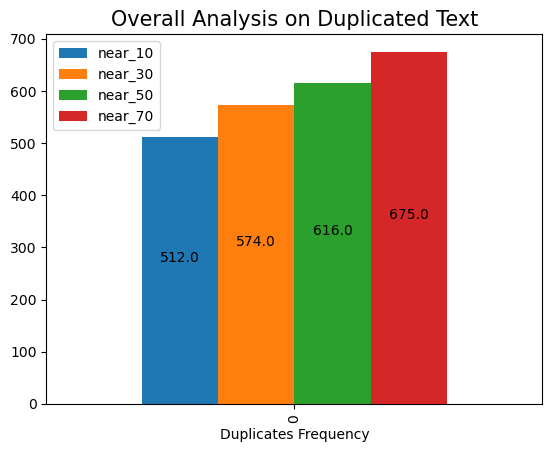

In [47]:
dups_overall = pd.DataFrame.from_dict({'near_10':[dups_10], 'near_30': [dups_30], 'near_50': [dups_50],'near_70':[dups_70]})

ax=dups_overall.plot(kind = 'bar',y=['near_10', 'near_30', 'near_50','near_70'], fontsize=10, color=['C0', 'C1', 'C2', 'C3'], align='center', width=0.8, xlabel="Duplicates Frequency")
ax.set_title('Overall Analysis on Duplicated Text', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [48]:
text_df.groupby('user_affiliated_organization').count()

user_affiliated_organization,count
higher_education,93039
other,5346778
news_related,121406
non_profit,14135
k_12,258364
government,146711


In [49]:
sample_highed = text_df.filter(text_df.user_affiliated_organization == 'higher_education').sample(0.06).limit(5000)
sample_highed.count()

5000

In [51]:
text = sample_highed.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .zipWithIndex()

row = Row('tweet_text')
df_text = text.map(row).zipWithIndex().toDF(['tweet_text','id'])

df_tokens_text = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens_text = df_tokens_text.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_text = vectorize.fit(df_tokens_text).transform(df_tokens_text)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize_text)
df_hashed = mh.fit(df_vectorize_text).transform(df_vectorize_text)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

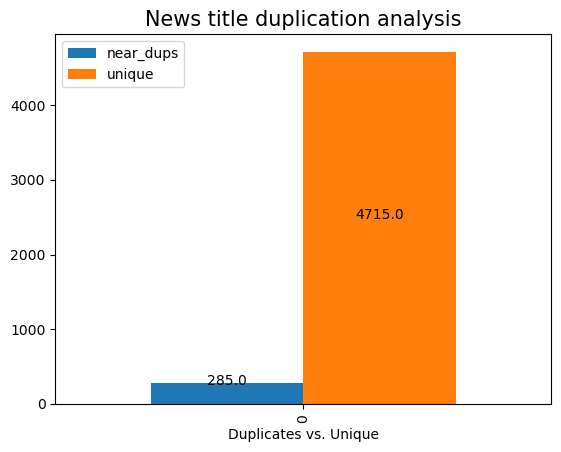

In [52]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B'))

df_dups_30 = df_dups_text

records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques_30 = records - dups
dups_30 = dups

dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques_30]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [56]:
sample_other = text_df.filter(text_df.user_affiliated_organization == 'other').sample(0.001).limit(5000)
sample_other.count()

5000

In [57]:
text = sample_other.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .zipWithIndex()

row = Row('tweet_text')
df_text = text.map(row).zipWithIndex().toDF(['tweet_text','id'])

df_tokens_text = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens_text = df_tokens_text.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_text = vectorize.fit(df_tokens_text).transform(df_tokens_text)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize_text)
df_hashed = mh.fit(df_vectorize_text).transform(df_vectorize_text)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

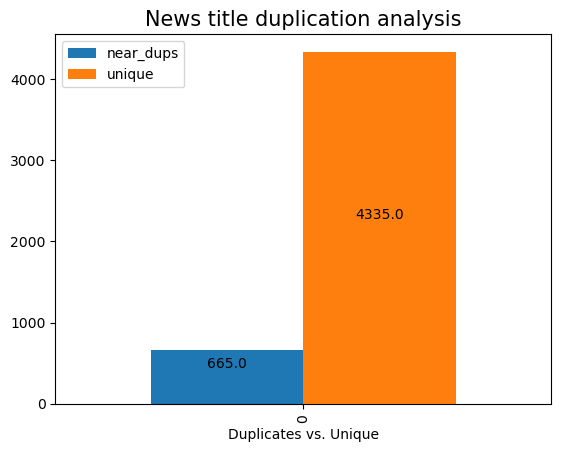

In [58]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B'))

df_dups_30 = df_dups_text

records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques_30 = records - dups
dups_30 = dups

dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques_30]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [59]:
sample_news = text_df.filter(text_df.user_affiliated_organization == 'news_related').sample(0.05).limit(5000)
sample_news.count()

5000

In [60]:
text = sample_news.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .zipWithIndex()

row = Row('tweet_text')
df_text = text.map(row).zipWithIndex().toDF(['tweet_text','id'])

df_tokens_text = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens_text = df_tokens_text.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_text = vectorize.fit(df_tokens_text).transform(df_tokens_text)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize_text)
df_hashed = mh.fit(df_vectorize_text).transform(df_vectorize_text)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

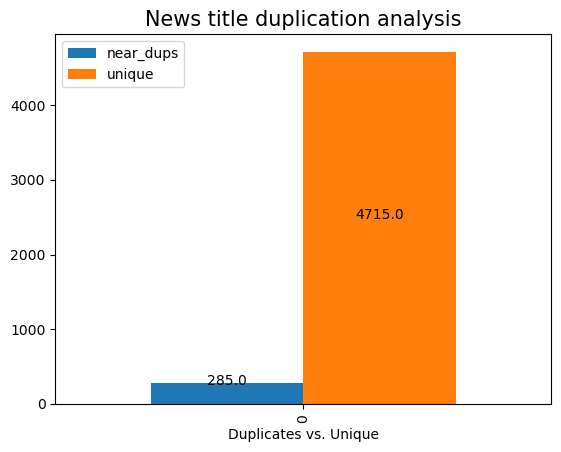

In [61]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B'))

df_dups_30 = df_dups_text

records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques_30 = records - dups
dups_30 = dups

dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques_30]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [62]:
sample_nonprof = text_df.filter(text_df.user_affiliated_organization == 'non_profit').sample(0.5).limit(5000)
sample_nonprof.count()

5000

In [63]:
text = sample_nonprof.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .zipWithIndex()

row = Row('tweet_text')
df_text = text.map(row).zipWithIndex().toDF(['tweet_text','id'])

df_tokens_text = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens_text = df_tokens_text.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_text = vectorize.fit(df_tokens_text).transform(df_tokens_text)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize_text)
df_hashed = mh.fit(df_vectorize_text).transform(df_vectorize_text)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

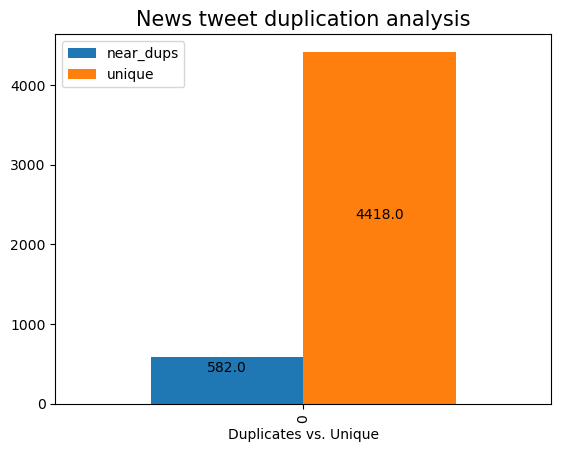

In [64]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B'))

df_dups_30 = df_dups_text

records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques_30 = records - dups
dups_30 = dups

dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques_30]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News tweet duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [65]:
sample_k12 = text_df.filter(text_df.user_affiliated_organization == 'k_12').sample(0.02).limit(5000)
sample_k12.count()

5000

In [66]:
text = sample_k12.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .zipWithIndex()

row = Row('tweet_text')
df_text = text.map(row).zipWithIndex().toDF(['tweet_text','id'])

df_tokens_text = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens_text = df_tokens_text.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_text = vectorize.fit(df_tokens_text).transform(df_tokens_text)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize_text)
df_hashed = mh.fit(df_vectorize_text).transform(df_vectorize_text)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

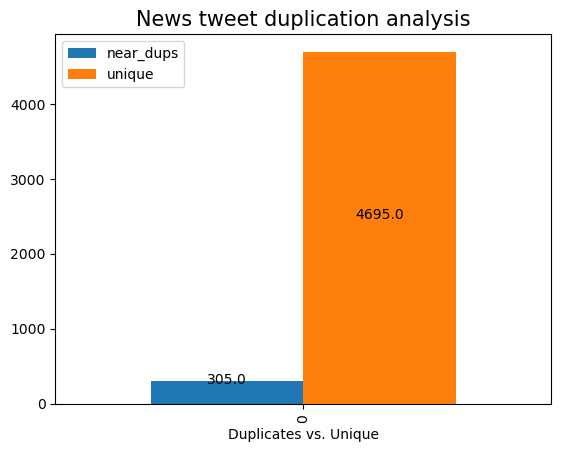

In [67]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B'))

df_dups_30 = df_dups_text

records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques_30 = records - dups
dups_30 = dups

dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques_30]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News tweet duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [68]:
sample_gov = text_df.filter(text_df.user_affiliated_organization == 'government').sample(0.05).limit(5000)
sample_gov.count()

5000

In [69]:
text = sample_gov.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .zipWithIndex()

row = Row('tweet_text')
df_text = text.map(row).zipWithIndex().toDF(['tweet_text','id'])

df_tokens_text = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens_text = df_tokens_text.where(col('list_of_words').getItem(0).isNotNull())

vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_text = vectorize.fit(df_tokens_text).transform(df_tokens_text)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize_text)
df_hashed = mh.fit(df_vectorize_text).transform(df_vectorize_text)

df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

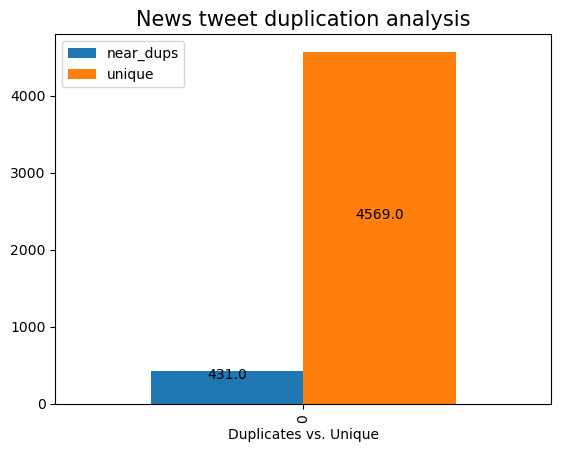

In [70]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"), 
            col('datasetA.tweet_text').alias('text_A'),
            col('datasetB.tweet_text').alias('text_B'))

df_dups_30 = df_dups_text

records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques_30 = records - dups
dups_30 = dups

dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques_30]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News tweet duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [71]:
elearning_df.write.format('parquet').\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/shared_data/qsliu/elearning_df')

23/02/26 23:02:01 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [72]:
df.write.format('parquet').\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/shared_data/qsliu/tweet_df')